In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

## Network topology and initialization functions

In [2]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer

def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

# Predictor

In [3]:
from jax.scipy.special import logsumexp

def relu(x):
    return jnp.maximum(0, x)

def predict(params, image):
    # per-example predictions
    activations = image
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)

    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

In [4]:
# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

# Utilities

In [5]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

# Data and Co.

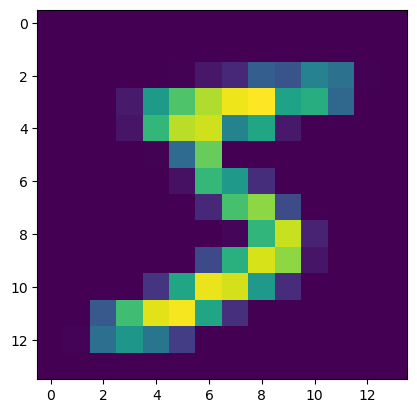

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow.keras.datasets as tfds
import numpy as np
onehot = lambda y : np.concatenate([
        (y == cifra)[:,None] * 1.
    for cifra in np.arange(10)
], axis = 1)

(x_train, y_train), (x_test, y_test) = tfds.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train = np.array([ np.array(Image.fromarray(x).resize((14,14))) for x in x_train])
x_test  = np.array([ np.array(Image.fromarray(x).resize((14,14))) for x in x_test])

plt.imshow(x_train[0])

x_train = x_train.reshape(-1,14*14)
x_test  = x_test.reshape(-1,14*14)
y_test  = onehot(y_test)
y_train = onehot(y_train)



# Training

In [7]:
layer_sizes = [14*14, 10, 10, 10]
step_size = 0.01
batch_epochs = 200
num_epochs = batch_epochs * 10
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

In [ ]:
import time
params = init_network_params(layer_sizes, random.PRNGKey(0))
for epoch in range(num_epochs):
    start_time = time.time()
    for i in range(10):
        batch = np.random.choice(len(x_train), size = 500)
        x,y = x_train[batch],y_train[batch]

    params = update(params, x, y)
    epoch_time = time.time() - start_time

    train_acc = accuracy(params, x_train, y_train)
    test_acc = accuracy(params,  x_test, y_test)
    if epoch % batch_epochs == 0:
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(train_acc))
        print("Test set accuracy {}".format(test_acc))

Epoch 0 in 1.14 sec
Training set accuracy 0.10301666706800461
Test set accuracy 0.10589999705553055
Epoch 200 in 0.00 sec
Training set accuracy 0.10700000077486038
Test set accuracy 0.11109999567270279
Epoch 400 in 0.00 sec
Training set accuracy 0.1307833343744278
Test set accuracy 0.1322999894618988
Epoch 600 in 0.00 sec
Training set accuracy 0.1960500031709671
Test set accuracy 0.19339999556541443
Epoch 800 in 0.00 sec
Training set accuracy 0.21043333411216736
Test set accuracy 0.2037999927997589
Epoch 1000 in 0.00 sec
Training set accuracy 0.5527333617210388
Test set accuracy 0.5541999936103821
Epoch 1200 in 0.00 sec
Training set accuracy 0.6970666646957397
Test set accuracy 0.7119999527931213


# Sparsification

## Definiamo la distanza $d$ su $\mathcal P$
<center> $d(\theta,\theta') = || f_{\theta} - f_{\theta'} ||_{L^2(\Omega)}$ </center>

In [65]:
import jax
def d(params_1, params_2):
    omega_sample = np.random.choice(255, size = (10000,14*14))
    return jnp.linalg.norm( batched_predict(params_1, omega_sample) - batched_predict(params_2, omega_sample) )
d = jax.jit(d)

params_perturbed = [ (p[0] + np.random.normal(size = p[0].shape) * .00001 ,p[1]) for p in params]
d(params,params_perturbed)

DeviceArray(0.7707645, dtype=float32)

# LOOP di calcolo

In [69]:
# trovo il peso piú piccolo
def clone_params(params):
    return [  [ np.array(p[0]).copy(),np.array(p[1]).copy()] for p in params]
    
def prune(params, cmp_params):
    minimo = 100.
    minimo_idx = 0
    minimo_i   = 0
    minimo_j   = 0
    
    for idx,p in enumerate(params):
        #print(idx)
        for i,row in enumerate(p[0]):
            #print("\t%d" % i , minimo)
            for j,el in enumerate(row):
                if params[idx][0][i,j] != 0.:
                    new_params = clone_params(params)
                    new_params[idx][0][i,j] = 0.
                    distanza =  d(cmp_params,new_params)
                    if(distanza < minimo):
                        minimo = distanza
                        minimo_idx = idx
                        minimo_i   = i
                        minimo_j   = j
                    if minimo == 0:         # if the minimum becomes zero then the current weight doees not affect distance in P space
                        return new_params
    new_params = clone_params(params)
    new_params[minimo_idx][0][minimo_i,minimo_j] = 0.
    return new_params

new_params = clone_params(params)
for i in range(100):
    new_params = prune(new_params, params)
    NZ = np.sum([ (p[0] != 0).sum() for p in new_params]) # non zero entries
    print(accuracy(new_params,  x_test, y_test) , NZ)

0.8127 2159
0.8127 2158
0.8127 2157
0.8127 2156
0.8127 2155
0.8127 2154
0.8127 2153
0.8127 2152
0.8127 2151
0.8127 2150
0.8127 2149
0.8127 2148
0.8127 2147
0.8127 2146
0.8127 2145
0.8127 2144
0.8127 2143
0.8127 2142
0.8127 2141
0.8127 2140
0.8127 2139
0.8127 2138
0.8127 2137
0.8127 2136
0.8127 2135
0.8127 2134
0.8127 2133
0.8127 2132
0.8127 2131
0.8127 2130
0.8127 2129
0.8127 2128
0.8127 2127
0.8127 2126
0.8127 2125
0.8127 2124
0.8127 2123
0.8127 2122
0.8127 2121
0.8127 2120
0.8127 2119
0.8127 2118
0.8127 2117
0.8127 2116
0.8127 2115
0.8127 2114
0.8127 2113
0.8127 2112
0.8127 2111
0.8127 2110
0.81259996 2109
0.81259996 2108
0.81259996 2107
0.81259996 2106
0.81259996 2105
0.81259996 2104
0.81259996 2103
0.81259996 2102
0.81259996 2101
0.81259996 2100
0.81259996 2099
0.81259996 2098
0.81259996 2097
0.81259996 2096
0.81259996 2095
0.81259996 2094
0.81259996 2093
0.81259996 2092
0.81259996 2091
0.81259996 2090
0.81259996 2089
0.81259996 2088
0.81259996 2087
0.81259996 2086
0.81259996 2085


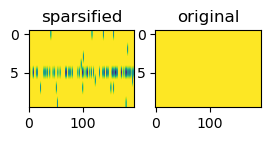

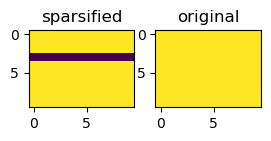

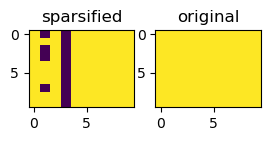

In [92]:
import matplotlib.pyplot as plt

for n,p in zip(new_params,params):
    axs = plt.figure(figsize=(3,1)).subplots(1,2)
    axs = axs.flatten()
    axs[0].set_title("sparsified")
    axs[0].imshow(n[0] != 0., vmin = 0.,vmax = 1.,aspect='auto') 
    axs[1].set_title("original")
    axs[1].imshow(p[0] != 0., vmin = 0.,vmax = 1.,aspect='auto')